# Metcalfe's Law and Bitcoin Price


The aim of this notebook is provide BTC price range estimate based the the amount of BTC wallets using [Metcalfe's Law](https://en.wikipedia.org/wiki/Metcalfe%27s_law).

According to [Metcalfe's Law](https://en.wikipedia.org/wiki/Metcalfe%27s_law) a value of networks (fully deluted market cap) is proportinal to the number of possible connection between their participants (wallets). As each partcipant can have _n-1_ connection, the value of the network, not cosidering the cost of the network, is :

> V=An(n-1)/2

If n is large and k=A/2 :

> V = k * n^2

_n_ is equated to the number of BTC addresses (_addressesCount_) holding more than certain amount of BTC (0.1/0.01/0.001)


In [1]:
import requests
import json
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'


from datetime import date
import time

# ----- User Settings 

coins=['BTC']  # Only BTC is available at cryptocompare


data_fetch_start_date = '2010-01-01'
plot_start_date = '2016-01-01'
k_calibration_start_date = '2016-01-01'
linear_fitting_start_date='2022-01-01'
extrapolation_end_date ='2040-01-01'

# Having more or same amount of BTC as [x,y,z]. This is for filtering out empty wallets
min_btcs =  [0.001]
# Reuqested Simple Moving Averages for calucating k
smas = [7,30,90,180, 365]


# cryptocompare.com API Key for fetching BTC wallet distributions and price
cryptocompare_api_key = '777db0605f662ba6667a0c8d385d317262bd221764d4a3b01dc7a629e9592a49'
# https://data.nasdaq.com/ token to use nasdaqdatalink for M2 money supply
nasdaqdatalink_token = 'JEn6xy3nc1JtFSLoXoVJ'
 
# ----- User Settings -- end





requestUrls = ['https://min-api.cryptocompare.com/data/blockchain/balancedistribution/histo/day?fsym={}&api_key={}&toTs={}&limit={}',
              'https://min-api.cryptocompare.com/data/v2/histoday?fsym={}&tsym=USD&api_key={}&toTs={}&limit={}']


limit=2000
data_fetch_start_date_ts = pd.Timestamp(data_fetch_start_date)
coin_dfs=[]
for coin in coins:
    time_segments = []
    timestamp = pd.Timestamp.now()
    while data_fetch_start_date_ts <= timestamp : 
        segment_dfs = []
        for requestUrl in requestUrls:
            segment_df = pd.DataFrame()
            requestUrl = requestUrl.format(coin, cryptocompare_api_key, timestamp.timestamp(),limit)
            # print("Request : " + requestUrl)    
            response = requests.get(requestUrl).text 
            parsed = json.loads(response)
            # print("Json : \n\n" + response)
            segment_df = pd.DataFrame(parsed['Data']['Data'])
            segment_df['time'] = pd.to_datetime(segment_df['time'], unit='s')
            segment_df.set_index(['time'],inplace=True, verify_integrity = True, drop = True)
            segment_df.sort_index(inplace=True)
            segment_dfs.append(segment_df)
        
        #segment_df.drop_duplicates(inplace=True)
        concated_segment_dfs= pd.concat(segment_dfs,axis=1)
        time_segments.append(concated_segment_dfs) 
        
        timestamp = segment_df.first_valid_index() - pd.Timedelta(1, "d") # -1 day    
        concated_segment_dfs.drop(columns=['volumefrom','volumeto','conversionType'
                                           ,'conversionSymbol', 'open','high','low'
                                           ,'id','symbol','partner_symbol'], inplace=True)
        #print("seg tail {}".format(concated_segment_dfs.tail(1)))

    df = pd.concat(time_segments, axis=0)
    df.sort_index(inplace=True)
    # print("Df {}\n".format(df))    
    df.dropna(inplace=True)
    df_wallet_ranges = [] 
    for i in range(10):
        df_wallet_range = pd.DataFrame()
        df_wallet_range['addressesCount'] = df['balance_distribution'].map(lambda x: x[i]['addressesCount'])
        df_wallet_range['totalVolume'] = df['balance_distribution'].map(lambda x: x[i]['totalVolume'])
        vindex= df.first_valid_index()  
        range_name = "{}-{}".format(df.loc[vindex,['balance_distribution']][0][i]['from'], 
                                    df.loc[vindex,['balance_distribution']][0][i]['to'])
        df_wallet_range =  pd.concat({range_name: df_wallet_range}, axis=1, names=["wallet_range", "metrics"]) 
        df_wallet_ranges.append(df_wallet_range)
    range_name = "all"
    df_wallet_range = pd.DataFrame()
    df_wallet_range['price'] = df['close']
    df_wallet_range = pd.concat({range_name: df_wallet_range}, axis=1, names=["wallet_range", "metrics"]) 
    df_wallet_ranges.append(df_wallet_range)
    
    df = pd.concat(df_wallet_ranges, axis=1)
 
    df = pd.concat({coin: df}, axis=1, names=["coin", "wallet_range", "metrics"])
    coin_dfs.append(df)
df=pd.concat(coin_dfs, axis=1)
df=df.loc[data_fetch_start_date_ts:]
df.sort_index(inplace=True)
df

coin                    BTC                                            \
wallet_range    1e-08-0.001                  0.001-0.01                 
metrics      addressesCount  totalVolume addressesCount   totalVolume   
time                                                                    
2010-01-01                0     0.000000              0      0.000000   
2010-01-02                0     0.000000              0      0.000000   
2010-01-03                0     0.000000              0      0.000000   
2010-01-04                0     0.000000              0      0.000000   
2010-01-05                0     0.000000              0      0.000000   
...                     ...          ...            ...           ...   
2023-04-17         23672124  4817.821366       10499779  39289.253016   
2023-04-18         23505702  4734.957732       10480643  39226.689456   
2023-04-19         23468608  4721.064134       10489060  39269.951837   
2023-04-20         23471503  4723.722103       10494183  39310.666363   
2023-04-21         23505672  4731.125191       10499012  39333.065572   

coin                                                                     \
wallet_range       0.01-0.1                         0.1-1                 
metrics      addressesCount    totalVolume addressesCount   totalVolume   
time                                                                      
2010-01-01                6       0.080000              3  1.500000e+00   
2010-01-02                6       0.080000              3  1.500000e+00   
2010-01-03                6       0.080000              3  1.500000e+00   
2010-01-04                6       0.080000              3  1.500000e+00   
2010-01-05                6       0.080000              3  1.500000e+00   
...                     ...            ...            ...           ...   
2023-04-17          7432306  250495.588423        3314576  1.030983e+06   
2023-04-18          7433307  250610.449263        3316439  1.031472e+06   
2023-04-19          7445250  250930.622887        3317911  1.031727e+06   
2023-04-20          7457229  251320.598589        3319299  1.032029e+06   
2023-04-21          7462613  251493.357592        3319880  1.032027e+06   

coin                                       ...                               \
wallet_range           1-10                ...        10-100       100-1000   
metrics      addressesCount   totalVolume  ...   totalVolume addressesCount   
time                                       ...                                
2010-01-01               10  2.344000e+01  ...  1.494773e+06             26   
2010-01-02               10  2.344000e+01  ...  1.501073e+06             26   
2010-01-03               10  2.344000e+01  ...  1.510373e+06             26   
2010-01-04               10  2.344000e+01  ...  1.515399e+06             26   
2010-01-05               10  2.344000e+01  ...  1.525299e+06             26   
...                     ...           ...  ...           ...            ...   
2023-04-17           838108  2.091852e+06  ...  4.437044e+06          13854   
2023-04-18           838104  2.091550e+06  ...  4.435891e+06          13860   
2023-04-19           838046  2.091232e+06  ...  4.435710e+06          13868   
2023-04-20           837985  2.091474e+06  ...  4.435697e+06          13873   
2023-04-21           838042  2.091698e+06  ...  4.432840e+06          13874   

coin                                                                    \
wallet_range                   1000-10000                 10000-100000   
metrics        totalVolume addressesCount   totalVolume addressesCount   
time                                                                     
2010-01-01    8.623200e+03              5  1.780001e+04              4   
2010-01-02    8.623200e+03              5  1.780001e+04              4   
2010-01-03    8.623200e+03              5  1.780001e+04              4   
2010-01-04    7.896860e+03              5  1.780001e+04              4   


In [2]:
df_aux = pd.DataFrame()

coin = coins[0] # 'BTC'

#aggregate_wallets=['0.1-1','1-10', '10-100','100-1000', '1000-10000', '10000-100000', '100000-1000000']
aggregate_wallets=['1-10', '10-100','100-1000', '1000-10000', '10000-100000']


#aggregate_wallets.append('1-10')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'1+','addressesCount')] = df_aux['addressesCount']

aggregate_wallets.append('0.1-1')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'0.1+','addressesCount')] = df_aux['addressesCount']


aggregate_wallets.append('0.01-0.1')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'0.01+','addressesCount')] = df_aux['addressesCount']


aggregate_wallets.append('0.001-0.01')
addressCounts = [df[coin][w_range]['addressesCount'] for w_range in aggregate_wallets]
df_aux['addressesCount'] = sum(addressCounts)
df.loc(axis=1)[(coin,'0.001+','addressesCount')] = df_aux['addressesCount']
#df.drop(columns=['100000-0','1e-08-0.001',*aggregate_wallets],inplace=True,level= "wallet_range")
df.drop(columns=['1e-08-0.001',*aggregate_wallets],inplace=True,level= "wallet_range")


df

coin                    BTC                                          \
wallet_range 100000-1000000                      all             1+   
metrics      addressesCount    totalVolume     price addressesCount   
time                                                                  
2010-01-01                0       0.000000      0.00          29950   
2010-01-02                0       0.000000      0.00          30076   
2010-01-03                0       0.000000      0.00          30262   
2010-01-04                0       0.000000      0.00          30363   
2010-01-05                0       0.000000      0.00          30561   
...                     ...            ...       ...            ...   
2023-04-17                4  673305.936351  29446.77         994057   
2023-04-18                4  673305.936351  30396.77         994038   
2023-04-19                4  673305.936351  28828.20         994034   
2023-04-20                4  673305.936351  28245.06         993907   
2023-04-21                4  673305.936351  27260.85         993820   

coin                                                       
wallet_range           0.1+          0.01+         0.001+  
metrics      addressesCount addressesCount addressesCount  
time                                                       
2010-01-01            29953          29959          29959  
2010-01-02            30079          30085          30085  
2010-01-03            30265          30271          30271  
2010-01-04            30366          30372          30372  
2010-01-05            30564          30570          30570  
...                     ...            ...            ...  
2023-04-17          4308633       11740939       22240718  
2023-04-18          4310477       11743784       22224427  
2023-04-19          4311945       11757195       22246255  
2023-04-20          4313206       11770435       22264618  
2023-04-21          4313700       11776313       22275325  

[4859 rows x 7 columns]

In [3]:
import nasdaqdatalink

def convert_to_m2(df,dt):
    iloc_idx = df.index.get_indexer([dt], method='nearest')  # returns absolute index into df e.g. array([5])
    loc_idx = df.index[iloc_idx]                             # if you want named index
    return df.loc[loc_idx,'Value'].values[0] 

wm2ns = nasdaqdatalink.get("FED/M2_N_WM", authtoken=nasdaqdatalink_token)    
df_m2 = pd.DataFrame(wm2ns)
df.loc(axis=1)[('USD','all', 'm2_supply')] = df.index.map(lambda dt: convert_to_m2(df_m2,dt))
btc_birthday = pd.to_datetime('2009-01-03')
m2_supply_at_genesis = convert_to_m2(df_m2,btc_birthday)
df.loc(axis=1)[('USD','all', 'm2_supply_index')] = df.loc(axis=1)[('USD','all', 'm2_supply')]/m2_supply_at_genesis
df.loc(axis=1)[(coin,'all', 'm2_adj_price')] = df.loc(axis=1)[('BTC','all', 'price')] /df.loc(axis=1)[('USD','all', 'm2_supply_index')]
df

coin                    BTC                                          \
wallet_range 100000-1000000                      all             1+   
metrics      addressesCount    totalVolume     price addressesCount   
time                                                                  
2010-01-01                0       0.000000      0.00          29950   
2010-01-02                0       0.000000      0.00          30076   
2010-01-03                0       0.000000      0.00          30262   
2010-01-04                0       0.000000      0.00          30363   
2010-01-05                0       0.000000      0.00          30561   
...                     ...            ...       ...            ...   
2023-04-17                4  673305.936351  29446.77         994057   
2023-04-18                4  673305.936351  30396.77         994038   
2023-04-19                4  673305.936351  28828.20         994034   
2023-04-20                4  673305.936351  28245.06         993907   
2023-04-21                4  673305.936351  27260.85         993820   

coin                                                            USD  \
wallet_range           0.1+          0.01+         0.001+       all   
metrics      addressesCount addressesCount addressesCount m2_supply   
time                                                                  
2010-01-01            29953          29959          29959    8501.7   
2010-01-02            30079          30085          30085    8501.7   
2010-01-03            30265          30271          30271    8501.7   
2010-01-04            30366          30372          30372    8501.7   
2010-01-05            30564          30570          30570    8501.7   
...                     ...            ...            ...       ...   
2023-04-17          4308633       11740939       22240718   21123.3   
2023-04-18          4310477       11743784       22224427   21123.3   
2023-04-19          4311945       11757195       22246255   21123.3   
2023-04-20          4313206       11770435       22264618   21123.3   
2023-04-21          4313700       11776313       22275325   21123.3   

coin                                   BTC  
wallet_range                           all  
metrics      m2_supply_index  m2_adj_price  
time                                        
2010-01-01          1.024363      0.000000  
2010-01-02          1.024363      0.000000  
2010-01-03          1.024363      0.000000  
2010-01-04          1.024363      0.000000  
2010-01-05          1.024363      0.000000  
...                      ...           ...  
2023-04-17          2.545129  11569.852609  
2023-04-18          2.545129  11943.114599  
2023-04-19          2.545129  11326.811904  
2023-04-20          2.545129  11097.691908  
2023-04-21          2.545129  10710.988556  

[4859 rows x 10 columns]

In [4]:

btc_max_supply = 21*10**6
for min_btc in min_btcs:
    df.loc(axis=1)[(coin,str(min_btc) + '+','k')] = btc_max_supply*df.loc(axis=1)[(coin,'all','m2_adj_price')] \
        / ( df.loc(axis=1)[(coin, str(min_btc) + '+','addressesCount')] \
        * df.loc(axis=1)[(coin, str(min_btc) + '+','addressesCount')])
    for days in smas: 
        df.loc(axis=1)[(coin, str(min_btc) + '+', 'k-sma' + str(days) +'d')] = \
            df.loc(axis=1)[(coin, str(min_btc) + '+','k')].rolling(days).mean()

# df=df.loc['2013-01-01':]
df

coin                    BTC                                          \
wallet_range 100000-1000000                      all             1+   
metrics      addressesCount    totalVolume     price addressesCount   
time                                                                  
2010-01-01                0       0.000000      0.00          29950   
2010-01-02                0       0.000000      0.00          30076   
2010-01-03                0       0.000000      0.00          30262   
2010-01-04                0       0.000000      0.00          30363   
2010-01-05                0       0.000000      0.00          30561   
...                     ...            ...       ...            ...   
2023-04-17                4  673305.936351  29446.77         994057   
2023-04-18                4  673305.936351  30396.77         994038   
2023-04-19                4  673305.936351  28828.20         994034   
2023-04-20                4  673305.936351  28245.06         993907   
2023-04-21                4  673305.936351  27260.85         993820   

coin                                                            USD  \
wallet_range           0.1+          0.01+         0.001+       all   
metrics      addressesCount addressesCount addressesCount m2_supply   
time                                                                  
2010-01-01            29953          29959          29959    8501.7   
2010-01-02            30079          30085          30085    8501.7   
2010-01-03            30265          30271          30271    8501.7   
2010-01-04            30366          30372          30372    8501.7   
2010-01-05            30564          30570          30570    8501.7   
...                     ...            ...            ...       ...   
2023-04-17          4308633       11740939       22240718   21123.3   
2023-04-18          4310477       11743784       22224427   21123.3   
2023-04-19          4311945       11757195       22246255   21123.3   
2023-04-20          4313206       11770435       22264618   21123.3   
2023-04-21          4313700       11776313       22275325   21123.3   

coin                                   BTC                                \
wallet_range                           all    0.001+                       
metrics      m2_supply_index  m2_adj_price         k   k-sma7d  k-sma30d   
time                                                                       
2010-01-01          1.024363      0.000000  0.000000       NaN       NaN   
2010-01-02          1.024363      0.000000  0.000000       NaN       NaN   
2010-01-03          1.024363      0.000000  0.000000       NaN       NaN   
2010-01-04          1.024363      0.000000  0.000000       NaN       NaN   
2010-01-05          1.024363      0.000000  0.000000       NaN       NaN   
...                      ...           ...       ...       ...       ...   
2023-04-17          2.545129  11569.852609  0.000491  0.000501  0.000471   
2023-04-18          2.545129  11943.114599  0.000508  0.000503  0.000473   
2023-04-19          2.545129  11326.811904  0.000481  0.000500  0.000473   
2023-04-20          2.545129  11097.691908  0.000470  0.000495  0.000473   
2023-04-21          2.545129  10710.988556  0.000453  0.000488  0.000473   

coin                                        
wallet_range                                
metrics       k-sma90d k-sma180d k-sma365d  
time                                        
2010-01-01         NaN       NaN       NaN  
2010-01-02         NaN       NaN       NaN  
2010-01-03         NaN       NaN       NaN  
2010-01-04         NaN       NaN       NaN  
2010-01-05         NaN       NaN       NaN  
...                ...       ...       ...  
2023-04-17    0.000422  0.000365  0.000412  
2023-04-18    0.000423  0.000366  0.000411  
2023-04-19    0.000425  0.000367  0.000410  
2023-04-20    0.000425  0.000367  0.000409  
2023-04-21    0.000426  0.000368  0.000408  

[4859 rows x 16 columns]

In [5]:
ranges_from_sma_days = 30

for min_btc in min_btcs:
    wallet_range = str(min_btc) + '+'
    k_btc_bottom = df[coin,wallet_range,'k-sma'+ str(ranges_from_sma_days)+ 'd'][k_calibration_start_date:].min()/btc_max_supply
    k_btc_top = df[coin, wallet_range,'k-sma'+ str(ranges_from_sma_days)+ 'd'][k_calibration_start_date:].max()/btc_max_supply
    df.loc(axis=1)[(coin, wallet_range, 'k_btc_bottom')] = k_btc_bottom
    df.loc(axis=1)[(coin, wallet_range, 'm2_adj_bottom_price')] = \
        k_btc_bottom * df.loc(axis=1)[(coin,wallet_range,'addressesCount')]**2
    df.loc(axis=1)[(coin, wallet_range, 'bottom_price')] = \
        df.loc(axis=1)[(coin,wallet_range, 'm2_adj_bottom_price')] * df.loc(axis=1)[('USD','all', 'm2_supply_index')]
    df.loc(axis=1)[(coin, wallet_range, 'k_btc_top')] = k_btc_top
    df.loc(axis=1)[(coin, wallet_range, 'm2_adj_top_price')] = \
        k_btc_top * df.loc(axis=1)[(coin,wallet_range,'addressesCount')]**2
    df.loc(axis=1)[(coin, wallet_range, 'top_price')] = \
        df.loc(axis=1)[(coin,wallet_range, 'm2_adj_top_price')] * df.loc(axis=1)[('USD','all', 'm2_supply_index')]
    #print("k top-to-bottom ratio is {} at range {} using k-sma-{}d ".format(k_btc_top/k_btc_bottom,min_btc,ranges_from_sma_days ) )


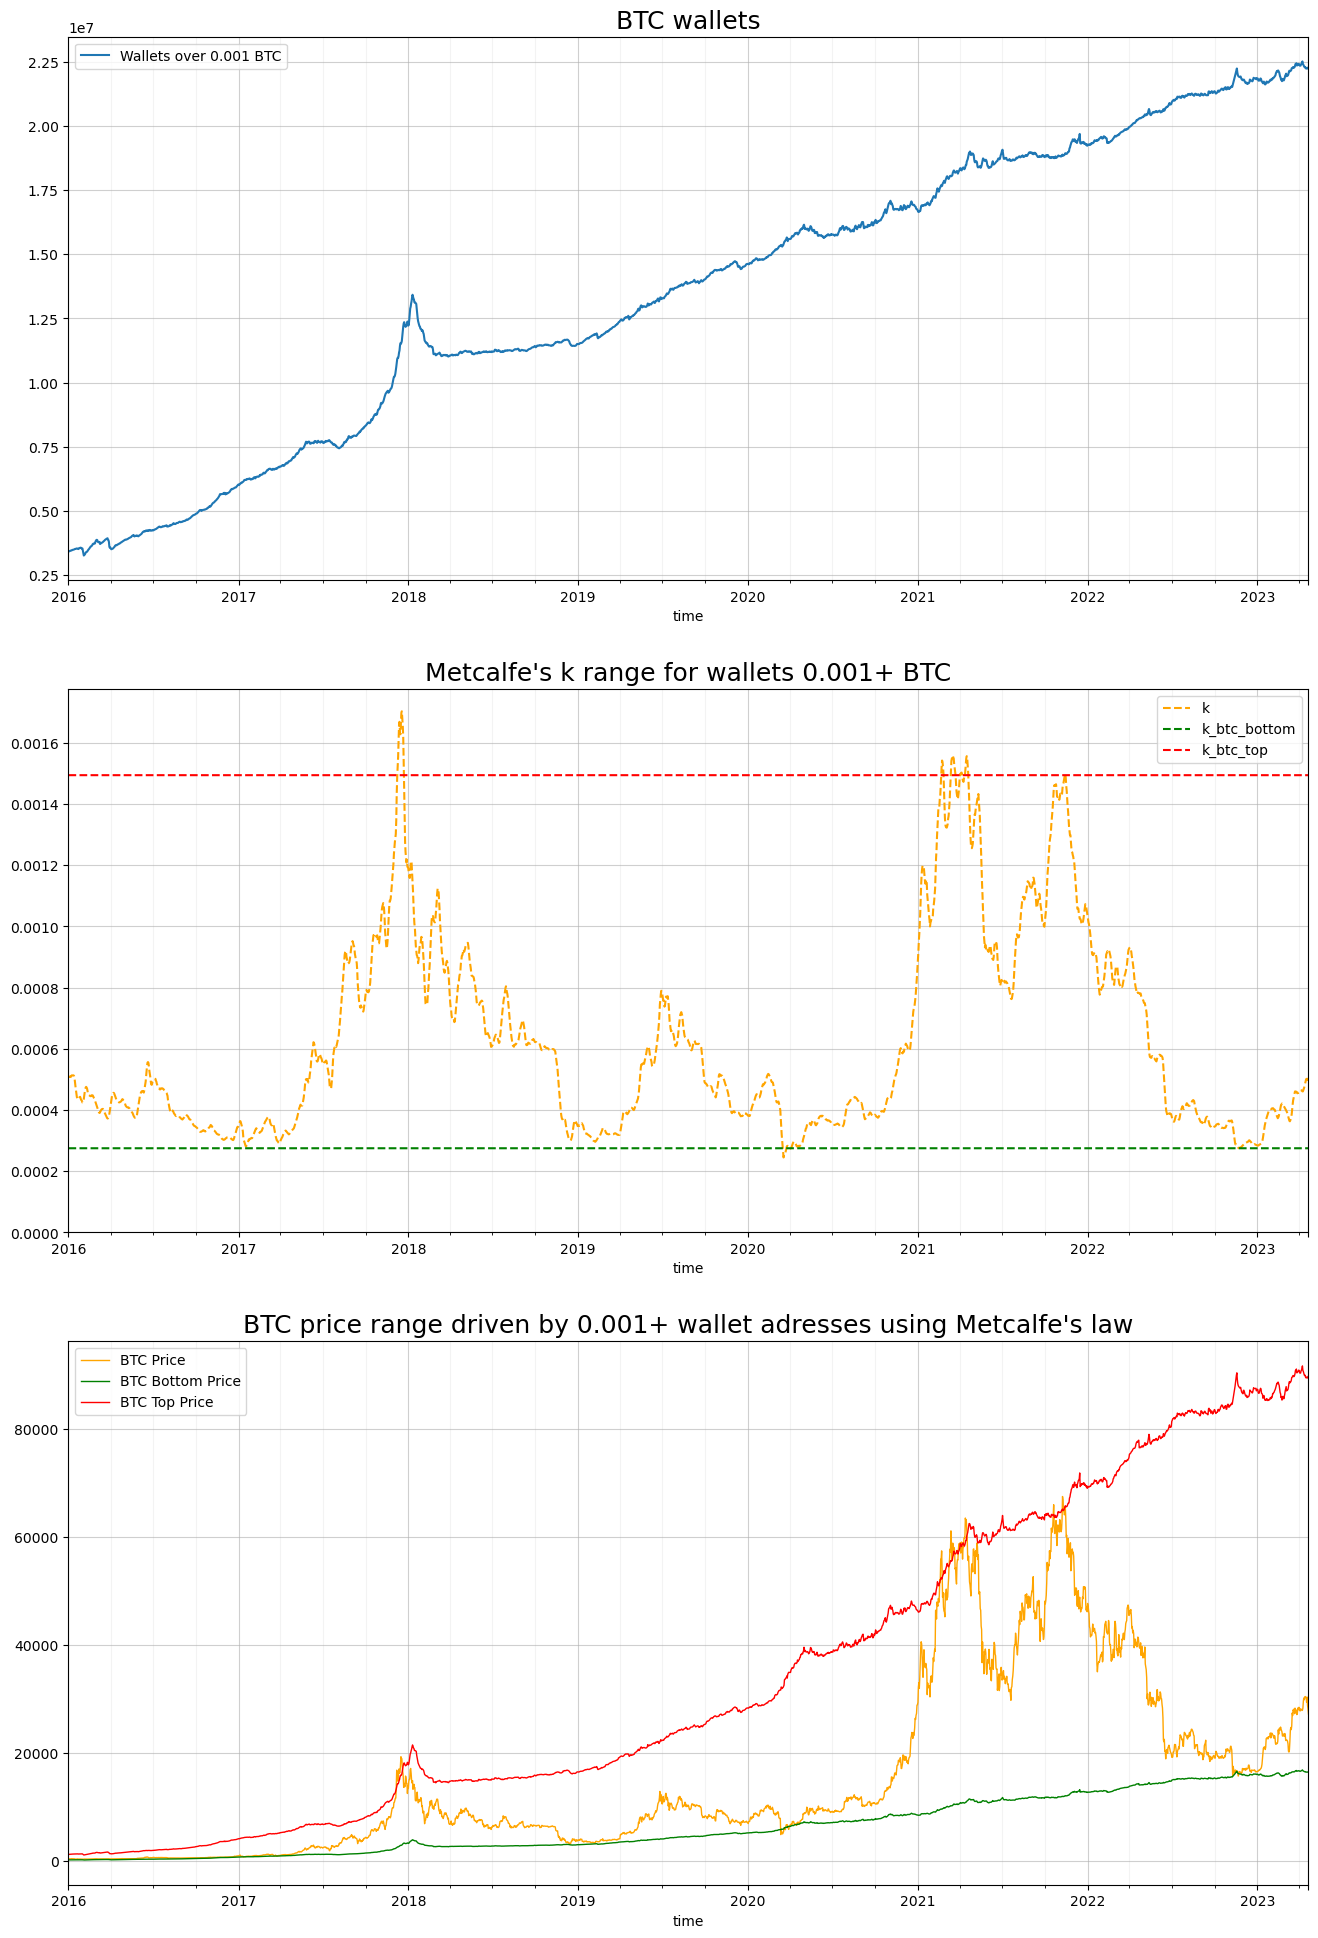

In [6]:
import matplotlib.pyplot as plt
today=df[df[coin]['all']['price'] >0 ].index.max()
subplots = 1+len(min_btcs)*2;
fig, axs = plt.subplots(subplots)
fig.set_size_inches(16, 8*subplots)

axs[0].set_title("{} wallets".format(coin), fontsize=18)
for min_btc in min_btcs:
    df[coin][str(min_btc)+'+']['addressesCount'][plot_start_date:today].plot(ax=axs[0],label='Wallets over {} {}'.format(min_btc, coin) )
axs[0].legend(loc='best')
axs[0].grid(axis='both', which='major', alpha=0.6)
axs[0].grid(axis='both', which='minor', alpha=0.15)  
i=1
for min_btc in min_btcs:
#for i in range(1,subplots,2) :
    
    wallet_range = str(min_btc)+'+'
    axs[i].set_title("Metcalfe's k range for wallets {} {}".format(wallet_range, coin), fontsize=18)
    df[coin][wallet_range]['k-sma7d'][plot_start_date:today].plot(ax=axs[i],color='orange',label='k'.format(wallet_range, coin), linestyle='dashed')
    (df[coin][wallet_range]['k_btc_bottom'][plot_start_date:today]*btc_max_supply).plot(ax=axs[i],color='green',label='k_btc_bottom', linestyle='dashed')
    (df[coin][wallet_range]['k_btc_top'][plot_start_date:today]*btc_max_supply).plot(ax=axs[i],color='red',label='k_btc_top', linestyle='dashed')
    axs[i].legend(loc='best')
    axs[i].grid(which='major', alpha=0.6)
    axs[i].grid(which='minor', alpha=0.15)
    axs[i].set_ylim([0,None])

    axs[i+1].set_title("{} price range driven by {} wallet adresses using Metcalfe's law".format(coin, wallet_range), fontsize=18)

    #m2_adj_='m2_adj_'
    m2_adj_=''
    if 'm2_adj_'  == m2_adj_:
        m2_adj_text = "USD M2 Supply adjusted "
    else:
         m2_adj_text = ""
    df[coin]['all'][m2_adj_ + 'price'][plot_start_date:today].plot(ax=axs[i+1], linewidth=1, color='orange',label='{}{} Price'.format(m2_adj_text, coin))
    df[coin][wallet_range][m2_adj_ + 'bottom_price'][plot_start_date:today].plot(ax=axs[i+1], linewidth=1,color='green',label='{}{} Bottom Price'.format(m2_adj_text, coin)) 
    df[coin][wallet_range][m2_adj_ + 'top_price'][plot_start_date:today].plot(ax=axs[i+1], linewidth=1,color='red',label='{}{} Top Price'.format(m2_adj_text, coin)) 
    #axs[i+1].set_yscale('log')
    axs[i+1].legend(loc='best')
    axs[i+1].grid(which='major', alpha=0.6)
    axs[i+1].grid(which='minor', alpha=0.15)     
    i=i+2

In [7]:
import math
import numpy as np
from datetime import date
def linear_growth(n,p_0,k):
    return k*n
def quadratic_growth(n,p_0,k):
    return k*n*n
def n_log_n_growth(n,p_0,k):
    return k*n*np.log2(n)

def limited_growth_function_log(t,p_0,k,l):
    return np.log2(l*p_0/( (l-p_0)*(math.e ** (-k*t))+p_0))
def limited_growth_function(t,p_0,k,l):
    return l*p_0/( (l-p_0)*(math.e ** (-k*t))+p_0)

from scipy.optimize import curve_fit
#p_0 = 314.25
p_0 = 4300000000.0
t_0 = pd.Timestamp('2015-01-01')
k = 7445.7718443355325
#l = 1*1000*1000*1000000

df.loc(axis=1)[(coin,'all','delta_days')] = (df.index-t_0).days
    

df

coin                    BTC                                          \
wallet_range 100000-1000000                      all             1+   
metrics      addressesCount    totalVolume     price addressesCount   
time                                                                  
2010-01-01                0       0.000000      0.00          29950   
2010-01-02                0       0.000000      0.00          30076   
2010-01-03                0       0.000000      0.00          30262   
2010-01-04                0       0.000000      0.00          30363   
2010-01-05                0       0.000000      0.00          30561   
...                     ...            ...       ...            ...   
2023-04-17                4  673305.936351  29446.77         994057   
2023-04-18                4  673305.936351  30396.77         994038   
2023-04-19                4  673305.936351  28828.20         994034   
2023-04-20                4  673305.936351  28245.06         993907   
2023-04-21                4  673305.936351  27260.85         993820   

coin                                                            USD  \
wallet_range           0.1+          0.01+         0.001+       all   
metrics      addressesCount addressesCount addressesCount m2_supply   
time                                                                  
2010-01-01            29953          29959          29959    8501.7   
2010-01-02            30079          30085          30085    8501.7   
2010-01-03            30265          30271          30271    8501.7   
2010-01-04            30366          30372          30372    8501.7   
2010-01-05            30564          30570          30570    8501.7   
...                     ...            ...            ...       ...   
2023-04-17          4308633       11740939       22240718   21123.3   
2023-04-18          4310477       11743784       22224427   21123.3   
2023-04-19          4311945       11757195       22246255   21123.3   
2023-04-20          4313206       11770435       22264618   21123.3   
2023-04-21          4313700       11776313       22275325   21123.3   

coin                                   BTC  ...                                \
wallet_range                           all  ...    0.001+                       
metrics      m2_supply_index  m2_adj_price  ...  k-sma90d k-sma180d k-sma365d   
time                                        ...                                 
2010-01-01          1.024363      0.000000  ...       NaN       NaN       NaN   
2010-01-02          1.024363      0.000000  ...       NaN       NaN       NaN   
2010-01-03          1.024363      0.000000  ...       NaN       NaN       NaN   
2010-01-04          1.024363      0.000000  ...       NaN       NaN       NaN   
2010-01-05          1.024363      0.000000  ...       NaN       NaN       NaN   
...                      ...           ...  ...       ...       ...       ...   
2023-04-17          2.545129  11569.852609  ...  0.000422  0.000365  0.000412   
2023-04-18          2.545129  11943.114599  ...  0.000423  0.000366  0.000411   
2023-04-19          2.545129  11326.811904  ...  0.000425  0.000367  0.000410   
2023-04-20          2.545129  11097.691908  ...  0.000425  0.000367  0.000409   
2023-04-21          2.545129  10710.988556  ...  0.000426  0.000368  0.000408   

coin                                                                        \
wallet_range                                                                 
metrics       k_btc_bottom m2_adj_bottom_price  bottom_price     k_btc_top   
time                                                                         
2010-01-01    1.310856e-11            0.011765      0.012052  7.116431e-11   
2010-01-02    1.310856e-11            0.011865      0.012154  7.116431e-11   
2010-01-03    1.310856e-11            0.012012      0.012304  7.116431e-11   
2010-01-04    1.310856e-11            0.012092      0.012387  7.116431e-11   
2010-01-05    1.310856e-11  

In [8]:
guess = [p_0, k]
today=df[df[coin]['all']['price'] >0 ].index.max()
min_date = df.index.min()
ix = pd.date_range(start=min_date, end=date.fromisoformat(extrapolation_end_date), freq='D')
df = df.reindex(ix)
df.loc(axis=1)[(coin,'all','delta_days')] = (df.index-t_0).days
#linear_fitting_start_date='2022-01-01'
print(today)

for min_btc in min_btcs:
    wallet_range = str(min_btc) + '+'
    parameters, covariance = curve_fit(linear_growth, df[coin]['all']['delta_days'][linear_fitting_start_date:today], df['BTC'][wallet_range]['addressesCount'][linear_fitting_start_date:today],p0=guess)
    print("p_0={}, k={}".format(parameters[0],parameters[1])
    df.loc(axis=1)[(coin,wallet_range,'addressesCount_linear_guess')]= linear_growth((df.index-t_0).days,p_0,k)
    df.loc(axis=1)[(coin,wallet_range,'addressesCount_linear_fit')]= linear_growth((df.index-t_0).days,parameters[0],parameters[1])

    df.loc(axis=1)[(coin, wallet_range, 'm2_adj_bottom_price_linear_fit')] = \
        k_btc_bottom * df.loc(axis=1)[(coin,wallet_range,'addressesCount_linear_fit')]**2
    df.loc(axis=1)[(coin, wallet_range, 'bottom_price_linear_fit')] = \
    df.loc(axis=1)[(coin, wallet_range, 'm2_adj_bottom_price_linear_fit')]  * df.loc(axis=1)[('USD','all', 'm2_supply_index')][today]   

    df.loc(axis=1)[(coin, wallet_range, 'm2_adj_top_price_linear_fit')] = \
        k_btc_top * df.loc(axis=1)[(coin,wallet_range,'addressesCount_linear_fit')]**2
    df.loc(axis=1)[(coin, wallet_range, 'top_price_linear_fit')] = \
    df.loc(axis=1)[(coin, wallet_range, 'm2_adj_top_price_linear_fit')]  * df.loc(axis=1)[('USD','all', 'm2_supply_index')][today]   
    
df


2023-04-21 00:00:00
p_0=4300000000.0, k=7517.785252648731, l=7517.785252648731


/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


coin                    BTC                                                  \
wallet_range 100000-1000000               all             1+           0.1+   
metrics      addressesCount totalVolume price addressesCount addressesCount   
2010-01-01              0.0         0.0   0.0        29950.0        29953.0   
2010-01-02              0.0         0.0   0.0        30076.0        30079.0   
2010-01-03              0.0         0.0   0.0        30262.0        30265.0   
2010-01-04              0.0         0.0   0.0        30363.0        30366.0   
2010-01-05              0.0         0.0   0.0        30561.0        30564.0   
...                     ...         ...   ...            ...            ...   
2039-12-28              NaN         NaN   NaN            NaN            NaN   
2039-12-29              NaN         NaN   NaN            NaN            NaN   
2039-12-30              NaN         NaN   NaN            NaN            NaN   
2039-12-31              NaN         NaN   NaN            NaN            NaN   
2040-01-01              NaN         NaN   NaN            NaN            NaN   

coin                                             USD                  \
wallet_range          0.01+         0.001+       all                   
metrics      addressesCount addressesCount m2_supply m2_supply_index   
2010-01-01          29959.0        29959.0    8501.7        1.024363   
2010-01-02          30085.0        30085.0    8501.7        1.024363   
2010-01-03          30271.0        30271.0    8501.7        1.024363   
2010-01-04          30372.0        30372.0    8501.7        1.024363   
2010-01-05          30570.0        30570.0    8501.7        1.024363   
...                     ...            ...       ...             ...   
2039-12-28              NaN            NaN       NaN             NaN   
2039-12-29              NaN            NaN       NaN             NaN   
2039-12-30              NaN            NaN       NaN             NaN   
2039-12-31              NaN            NaN       NaN             NaN   
2040-01-01              NaN            NaN       NaN             NaN   

coin                  BTC  ...                                           \
wallet_range          all  ...        0.001+                              
metrics      m2_adj_price  ...     k_btc_top m2_adj_top_price top_price   
2010-01-01            0.0  ...  7.116431e-11         0.063873  0.065429   
2010-01-02            0.0  ...  7.116431e-11         0.064411  0.065981   
2010-01-03            0.0  ...  7.116431e-11         0.065210  0.066799   
2010-01-04            0.0  ...  7.116431e-11         0.065646  0.067245   
2010-01-05            0.0  ...  7.116431e-11         0.066505  0.068125   
...                   ...  ...           ...              ...       ...   
2039-12-28            NaN  ...           NaN              NaN       NaN   
2039-12-29            NaN  ...           NaN              NaN       NaN   
2039-12-30            NaN  ...           NaN              NaN       NaN   
2039-12-31            NaN  ...           NaN              NaN       NaN   
2040-01-01            NaN  ...           NaN              NaN       NaN   

coin                                                                           \
wallet_range        all                      0.001+                             
metrics      delta_days addressesCount_linear_guess addressesCount_linear_fit   
2010-01-01        -1826               -1.359598e+07             -1.372748e+07   
2010-01-02        -1825               -1.358853e+07             -1.371996e+07   
2010-01-03        -1824               -1.358109e+07             -1.371244e+07   
2010-01-04        -1823               -1.357364e+07             -1.370492e+07   
2010-01-05        -1822               -1.356620e+07             -1.369740e+07   
...                 ...                         ...                       ...   
2039-12-28         9127                6.795756e+07              6.861483e+07   
2039-12-29         9128

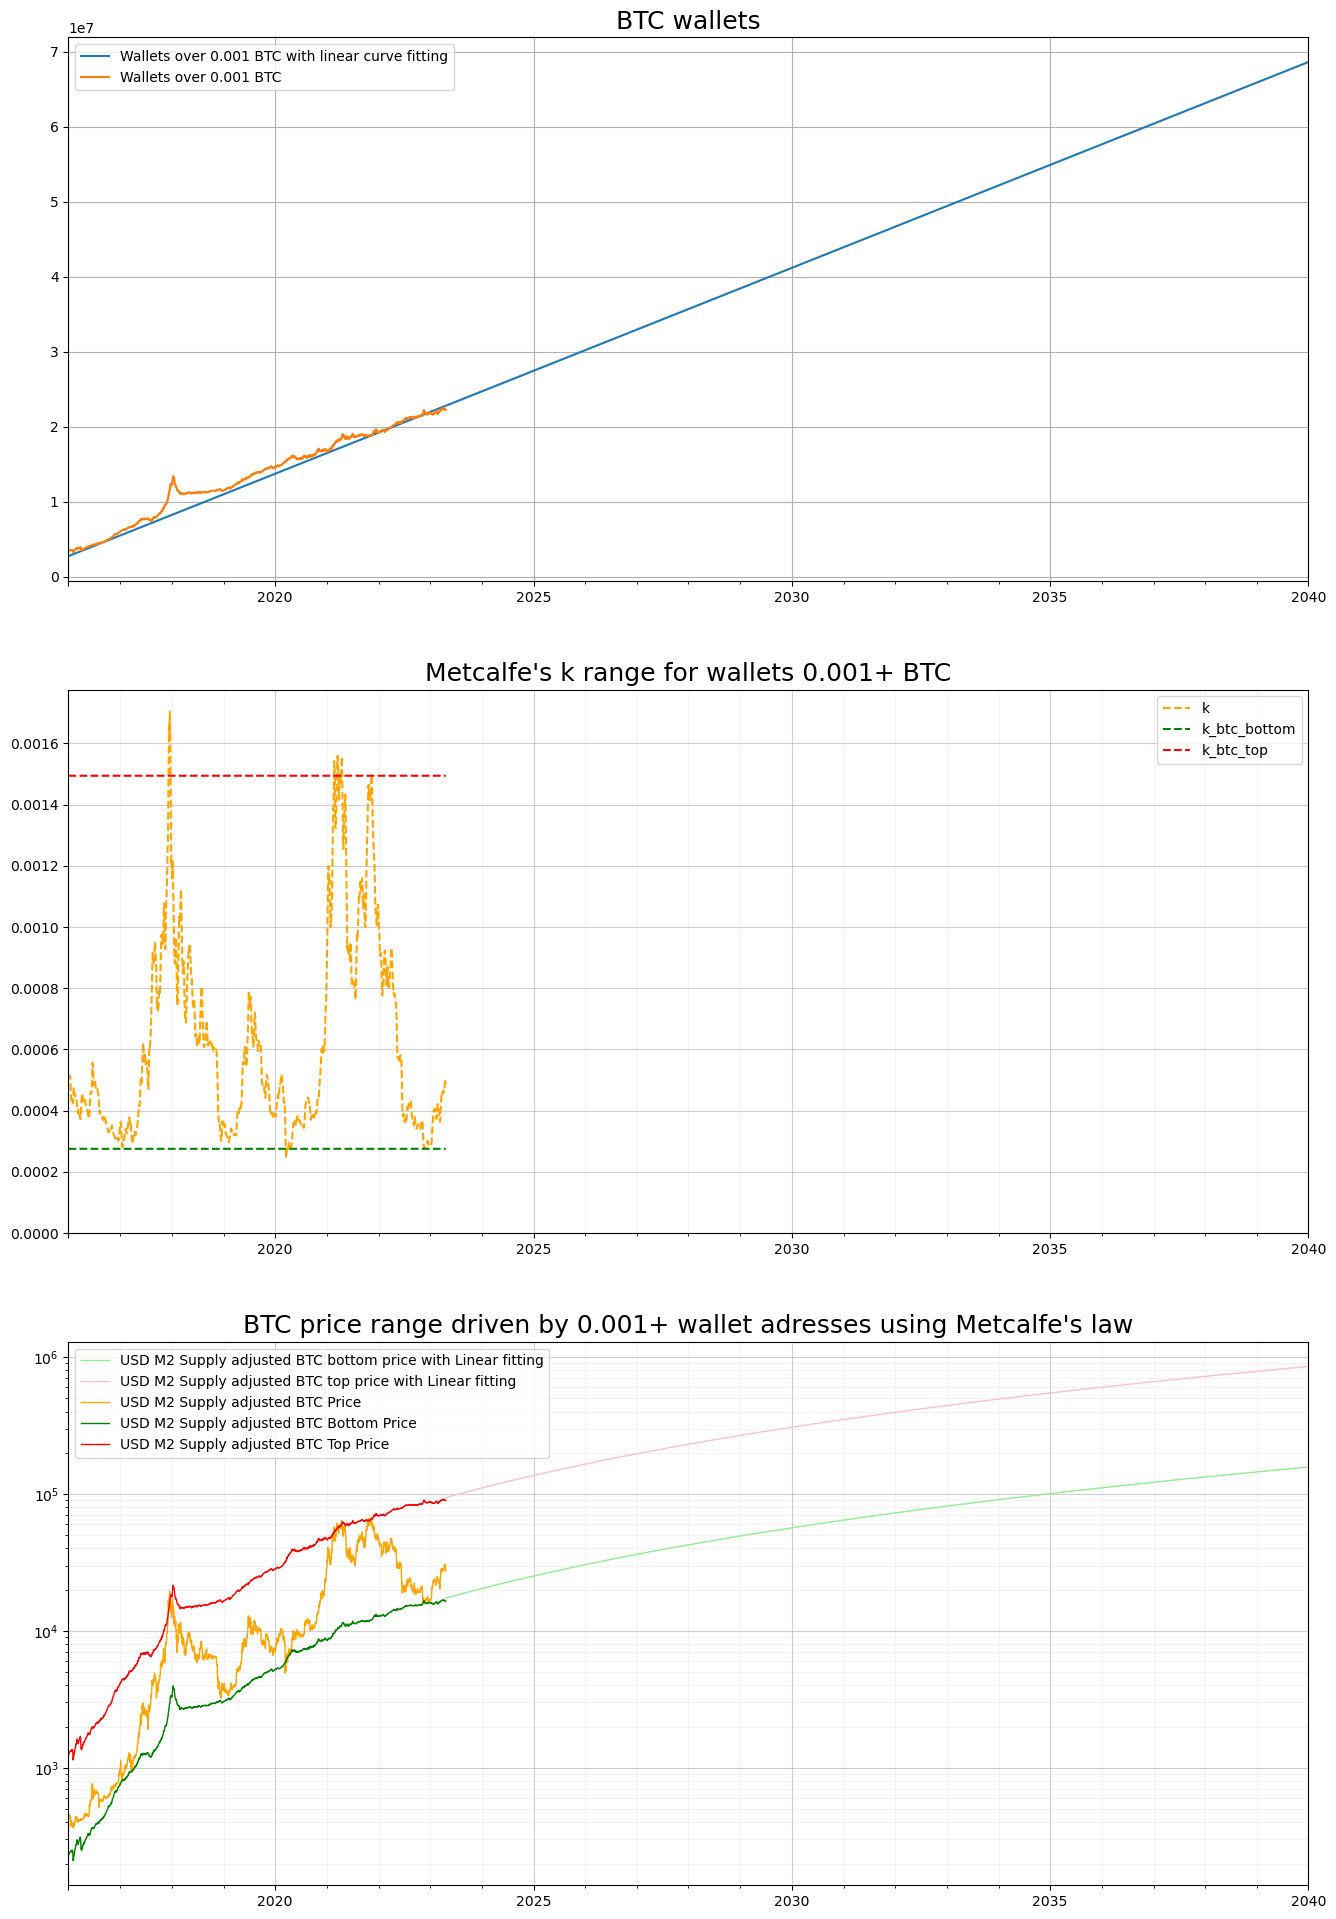

In [9]:
import matplotlib.pyplot as plt
subplots = 1+len(min_btcs)*2;
fig, axs = plt.subplots(subplots)
fig.set_size_inches(16, 8*subplots)

axs[0].set_title("{} wallets".format(coin), fontsize=18)
for min_btc in min_btcs:
    df[coin][str(min_btc)+'+']['addressesCount_linear_fit'][plot_start_date:].plot(ax=axs[0],label='Wallets over {} {} with linear curve fitting'.format(min_btc, coin) )
#    df[coin][str(min_btc)+'+']['addressesCount_linear_guess'].plot(ax=axs[0],label='Wallets over {} {} with linear guess'.format(min_btc, coin) )
    df[coin][str(min_btc)+'+']['addressesCount'][plot_start_date:today].plot(ax=axs[0],label='Wallets over {} {}'.format(min_btc, coin) )
axs[0].legend(loc='best')
axs[0].grid()
i=1
for min_btc in min_btcs:
#for i in range(1,subplots,2) :
    
    wallet_range = str(min_btc)+'+'
    axs[i].set_title("Metcalfe's k range for wallets {} {}".format(wallet_range, coin), fontsize=18)
    df[coin][wallet_range]['k-sma7d'][plot_start_date:].plot(ax=axs[i],color='orange',label='k'.format(wallet_range, coin), linestyle='dashed')
    (df[coin][wallet_range]['k_btc_bottom'][plot_start_date:]*btc_max_supply).plot(ax=axs[i],color='green',label='k_btc_bottom', linestyle='dashed')
    (df[coin][wallet_range]['k_btc_top'][plot_start_date:]*btc_max_supply).plot(ax=axs[i],color='red',label='k_btc_top', linestyle='dashed')
    axs[i].legend(loc='best')
    axs[i].set_ylim([0,None])
    axs[i].grid(which='major', alpha=0.6)
    axs[i].grid(which='minor', alpha=0.15) 
    axs[i+1].set_title("{} price range driven by {} wallet adresses using Metcalfe's law".format(coin, wallet_range), fontsize=18)

    #m2_adj_='m2_adj_'
    m2_adj_=''
    wallet_range
    df[coin][wallet_range][m2_adj_ + 'bottom_price_linear_fit'][today:].plot(ax=axs[i+1], linewidth=1, color='lightgreen',label='USD M2 Supply adjusted {} bottom price with Linear fitting'.format(coin))
    df[coin][wallet_range][m2_adj_ + 'top_price_linear_fit'][today:].plot(ax=axs[i+1], linewidth=1, color='pink',label='USD M2 Supply adjusted {} top price with Linear fitting'.format(coin))

    df[coin]['all'][m2_adj_ + 'price'][plot_start_date:].plot(ax=axs[i+1], linewidth=1, color='orange',label='USD M2 Supply adjusted {} Price '.format(coin))

    df[coin][wallet_range][m2_adj_ + 'bottom_price'][plot_start_date:].plot(ax=axs[i+1], linewidth=1,color='green',label='USD M2 Supply adjusted {} Bottom Price'.format(coin)) 
    df[coin][wallet_range][m2_adj_ + 'top_price'][plot_start_date:].plot(ax=axs[i+1], linewidth=1,color='red',label='USD M2 Supply adjusted {} Top Price'.format(coin)) 
    axs[i+1].set_yscale('log')
    axs[i+1].legend(loc='best')
    axs[i+1].grid(which='major', alpha=0.6)
    axs[i+1].grid(which='minor', alpha=0.15) 
    i=i+2